# Lista prática I

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynp

## Vizinhos mais próximos

**Exercício 1.** O código abaixo carrega o dataset MNIST, que consiste em imagens de dígitos entre $0$ e $9$. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 5) e reporte a acurácia para cada valor de $k$. Lembre que a acurácia é o percentual de amostras classificadas corretamente. Notavelmente, as entradas do MNIST tem dimensão relativamente alta (64). Plote uma imagem com a variância amostral dos pixels das imagens e comente. Também mostre as imagens classificadas de maneira errônea e comente.

In [14]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits, make_moons
from sklearn.model_selection import train_test_split
from numpy.linalg import norm


SEED = 42
np.random.seed(SEED)

@dataclass
class Dataset:
    features_train: np.ndarray 
    features_test: np.ndarray  
    labels_train: np.ndarray   
    labels_test: np.ndarray

# Import dataset and separate train/test subsets
mnist = Dataset(*train_test_split(
    *load_digits(return_X_y=True),
    random_state=SEED,
))

In [15]:
def calculate_distances(features_train, features_test):
    """
    Calcula a distância euclidiana entre cada ponto de teste e todos os pontos de treino.
    A entrada (i,j) é a distância entre o i-ésimo ponto de teste e o j-ésimo ponto de treino.
    
    features_train: np.ndarray de shape (n_train, n_features)
    features_test: np.ndarray de shape (n_test, n_features)
    return: np.ndarray de shape (n_test, n_train) com as distancias
    """
    distances_all = []

    # Para cada ponto de teste
    for test_point in features_test:

        # Calcule a distância para todos os pontos de treino
        distances = norm(features_train - test_point, axis=1)
        distances_all.append(distances)
    return np.array(distances_all)

In [16]:
def accuracy_result(k, dataset, distances_all):
    """
    Calcula a acurácia do k-NN para um determinado valor de k.
    k: número de vizinhos a serem considerados.
    dataset: conjunto de dados a ser utilizado.
    distances_all: matriz de distâncias entre pontos de treino e teste.
    """
    correct = 0

    # Para cada ponto de teste
    for i, testing_point in enumerate(dataset.features_test):

        # Tome os k vizinhos mais próximos
        nearest_indices = np.argpartition(distances_all[i], k)[:k]

        # Considere seus rótulos
        nearest_labels = dataset.labels_train[nearest_indices]

        # E faça a votação majoritária
        predicted_label = np.bincount(nearest_labels).argmax()

        if predicted_label == dataset.labels_test[i]:
            correct += 1

    accuracy = correct / len(dataset.labels_test)
    print(f"k = {k} : {accuracy}\n")

In [17]:
# Calcule as distâncias entre os pontos de treino e teste
distances_all = calculate_distances(
    mnist.features_train,
    mnist.features_test
)

In [18]:
print("Acurácia para diferentes valores de k:\n")
accuracy_result(1, dataset=mnist, distances_all=distances_all)
accuracy_result(2, dataset=mnist, distances_all=distances_all)
accuracy_result(3, dataset=mnist, distances_all=distances_all)
accuracy_result(4, dataset=mnist, distances_all=distances_all)
accuracy_result(5, dataset=mnist, distances_all=distances_all)

Acurácia para diferentes valores de k:

k = 1 : 0.9822222222222222

k = 2 : 0.9844444444444445

k = 3 : 0.9866666666666667

k = 4 : 0.9866666666666667

k = 5 : 0.9933333333333333



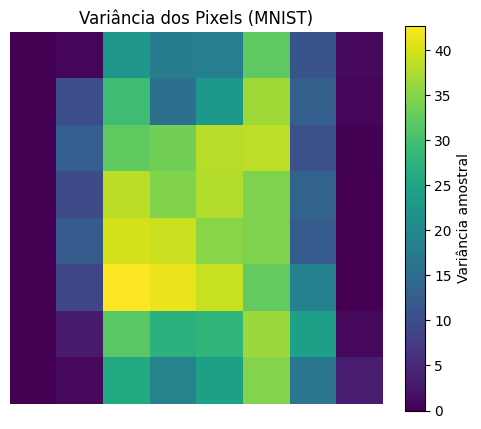

In [19]:
# Concatenar dados de treno e teste
mnist_all = np.concatenate((mnist.features_test, mnist.features_train))

# Calcular a variância de cada pixel
variance = np.var(mnist_all, axis=0, ddof=1)

# Redimensionar para que a imagem seja 8x8
variance_img = variance.reshape(8, 8)

plt.figure(figsize=(6, 5))
plt.imshow(variance_img)
plt.colorbar(label='Variância amostral')
plt.title('Variância dos Pixels (MNIST)')
plt.axis('off')
plt.show()

**Exercício 02.** O código abaixo carrega o dataset "two moons", que consiste de amostras bidimensionais divididas em duas classes. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 10). Plote a superfície de decisão para cada valor de $k$. Como $k$ influencia na suavidade dessas superfícies?

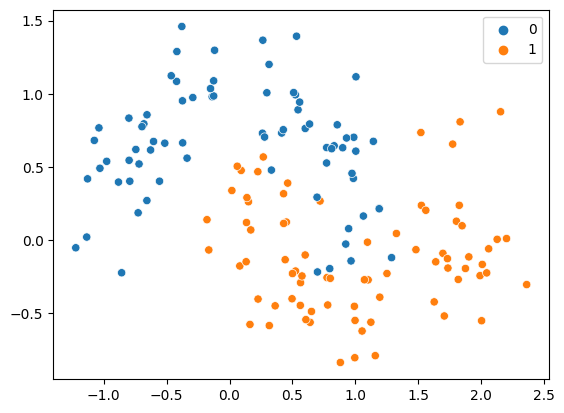

In [20]:
# Import dataset and separate train/test subsets
moon = Dataset(*train_test_split(
    *make_moons(n_samples=200, shuffle=True, noise=0.25, random_state=SEED),
    random_state=SEED,
))

# Let's also plot the moon dataset, for you to take a look at it.
sns.scatterplot(
    x=moon.features_train[:, 0],
    y=moon.features_train[:, 1],
    hue=moon.labels_train,
)
plt.show()

In [21]:
# Calcule as distâncias entre os pontos de treino e teste
distances_all = calculate_distances(
    moon.features_train,
    moon.features_test
)

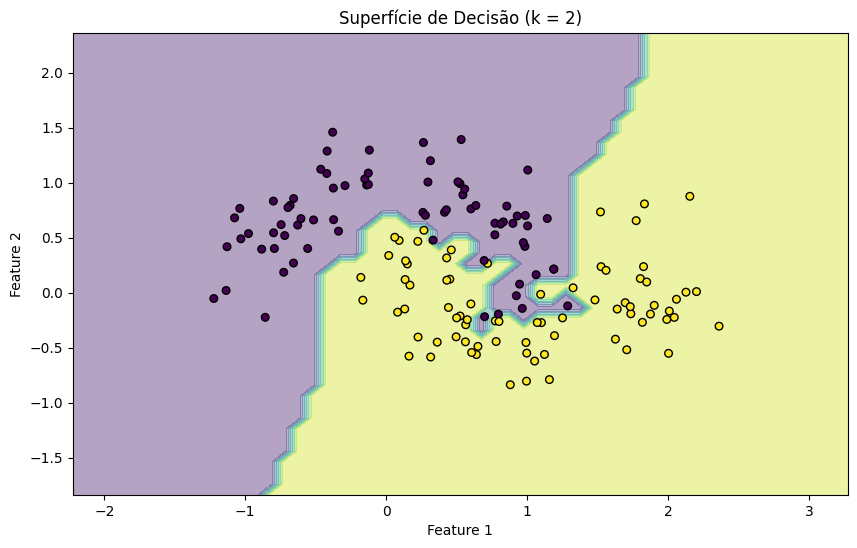

In [22]:
def create_meshgrid(X, step=0.1):
    """
    Cria uma malha de pontos baseada nos dados de entrada X.
    X: np.ndarray de shape (n_samples, n_features).
    step: passo da malha de pontos.
    return: xx, yy, meshgrid com os pontos da malha.
    """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, step),
        np.arange(y_min, y_max, step)
    )
    return xx, yy

# Cria uma malha de pontos
xx, yy = create_meshgrid(moon.features_train, step=0.1)
grid_points = np.c_[xx.ravel(), yy.ravel()]  # Achatar malha em lista de pontos

# Calcular as distâncias entre os pontos de treino e a malha
distances_mesh = calculate_distances(moon.features_train, grid_points)

def predict_knn(index, k=5):
    """
    Faz a predição do rótulo de um ponto baseado nos k vizinhos mais próximos.	
    """
    distances = distances_mesh[index] 

    # Ache os k vizinhos mais próximos
    nearest_indices = np.argsort(distances)[:k]  

    # Conte ocorrencias de cada classe
    class_counts = {}
    for idx in nearest_indices:
        label = moon.labels_train[idx]  
        class_counts[label] = class_counts.get(label, 0) + 1

    # Retorne a classe mais comum
    return max(class_counts, key=class_counts.get)

# Predição para todos os pontos da malha
Z = np.array([predict_knn(i, k=2) for i in range(len(grid_points))])
Z = Z.reshape(xx.shape)  # Reformatar para o formato da malha

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4)  # Superficie de decisão
plt.scatter(moon.features_train[:, 0], moon.features_train[:, 1], c=moon.labels_train, s=30, edgecolor='k')  
plt.title(f'Superfície de Decisão (k = {2})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

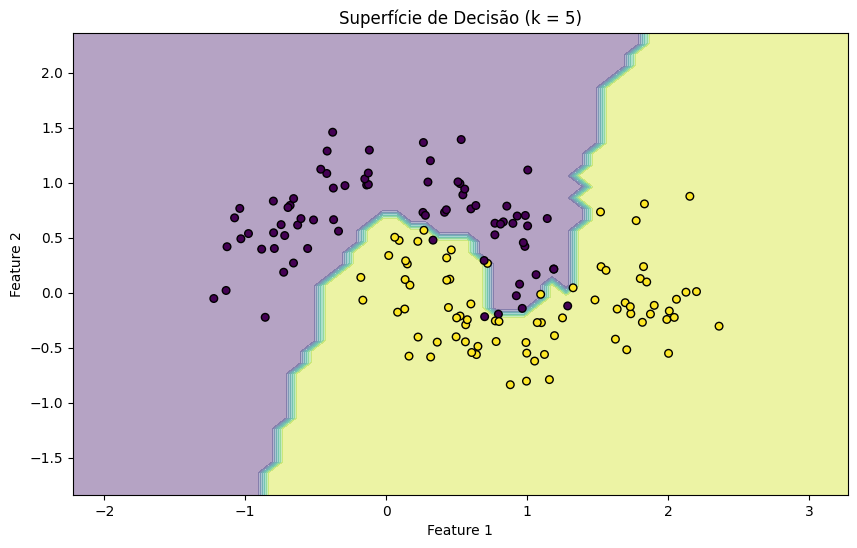

In [23]:
Z = np.array([predict_knn(i, k=4) for i in range(len(grid_points))])
Z = Z.reshape(xx.shape)  # Reformatar para o formato da malha

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4)  # Superficie de decisão
plt.scatter(moon.features_train[:, 0], moon.features_train[:, 1], c=moon.labels_train, s=30, edgecolor='k')  
plt.title(f'Superfície de Decisão (k = {5})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

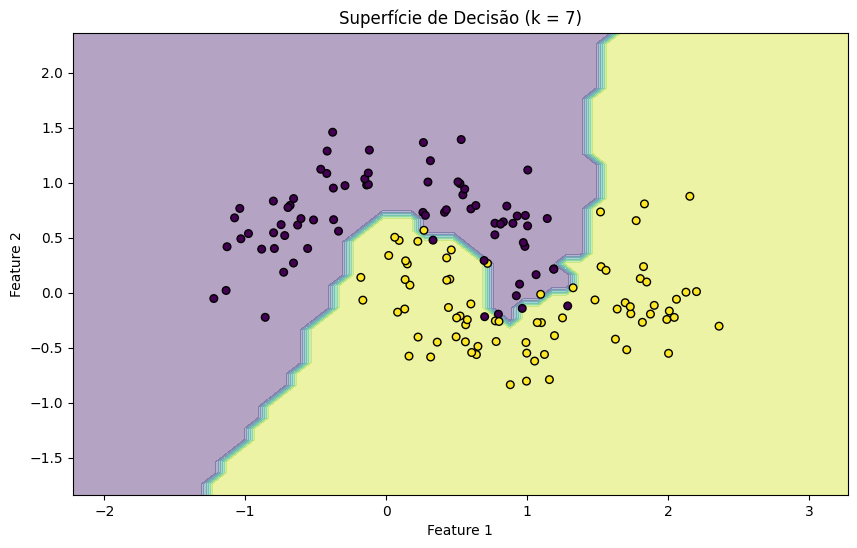

In [24]:
Z = np.array([predict_knn(i, k=7) for i in range(len(grid_points))])
Z = Z.reshape(xx.shape)  # Reformatar para o formato da malha

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4)  # Superficie de decisão
plt.scatter(moon.features_train[:, 0], moon.features_train[:, 1], c=moon.labels_train, s=30, edgecolor='k')  
plt.title(f'Superfície de Decisão (k = {7})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

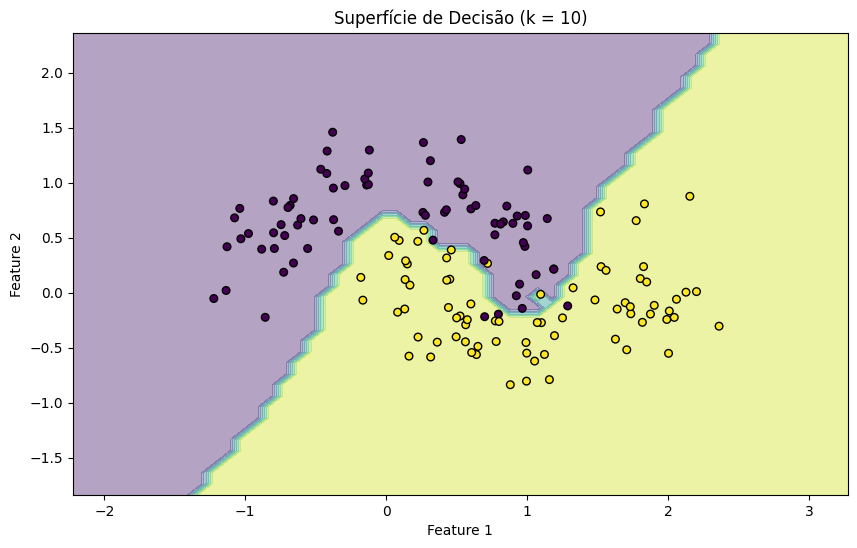

In [25]:
Z = np.array([predict_knn(i, k=10) for i in range(len(grid_points))])
Z = Z.reshape(xx.shape)  # Reformatar para o formato da malha

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4)  # Superficie de decisão
plt.scatter(moon.features_train[:, 0], moon.features_train[:, 1], c=moon.labels_train, s=30, edgecolor='k')  
plt.title(f'Superfície de Decisão (k = {10})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [26]:
distances_all_moons = calculate_distances(
    moon.features_train,
    moon.features_test
)

print("Acurácia para diferentes valores de k:\n")
accuracy_result(2, dataset=moon, distances_all=distances_all_moons)
accuracy_result(4, dataset=moon, distances_all=distances_all_moons)
accuracy_result(8, dataset=moon, distances_all=distances_all_moons)
accuracy_result(10, dataset=moon, distances_all=distances_all_moons)
accuracy_result(15, dataset=moon, distances_all=distances_all_moons)

Acurácia para diferentes valores de k:

k = 2 : 0.92

k = 4 : 0.92

k = 8 : 0.92

k = 10 : 0.94

k = 15 : 0.94



_Para valores menores de $k$, a superfície parace menos suave e parece estar overfittando. Para valores maiores de $k$, a superfície fica cada vez mais suave._

# Regressão linear

**Exercício 1.** Deixamos à sua disposição o dataset ["California Housing"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), dividio em treino, teste e validação.
O modelo que você utilizará para aproximar a relação funcional entre as features e as labels é o modelo linear, i.e., $\mathbf{y} = X\theta$.
Entretanto, você deve estimar seus parâmetros (minimizando o *mean squared error*) com **dois algoritmos diferentes**.
Uma implementação deve estimar $\theta$ por meio de **Stochastic Gradient Descent (SGD)** e, a outra, por meio de **Ordinary Least Squares (OLS)**, ou seja, utilizar a solução em fórmula fechada vista em aula.

Para o SGD, o ponto inicial deve ser escolhido aleatoriamente e o algoritmo deve parar quando a norma da diferença entre duas estimativas consecutivas de $\theta$ for menor do que um $\varepsilon > 0$ previamente especificado.
Para o experimento a seguir, fixe $\varepsilon$ em um valor pequeno (por exemplo, alguma potência de $1/10$) para a qual o algoritmo convirja no máximo em alguns minutos para uma solução com perda pequena.

Para diferentes tamanhos de minibatch (por exemplo $\{2^{j}: 1 \leq j \leq 7\}$), plote um gráfico representando o valor da perda $ L(\hat{\theta}) = \frac{1}{n} \lVert X \hat{\theta} - \mathbf{y} \rVert^{2}$ no conjunto de validação em função do número de epochs. Mostre também o valor ótimo obtido com OLS. Comente os resultados e o efeito tamanho do mini-batch, e.g., no tempo de treinamento. Reporte valores nos conjuntos de treino, validação e teste.

In [27]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)


features, labels = fetch_california_housing(return_X_y=True)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.25
)
features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train, labels_train, test_size=0.25
)

In [41]:
def compute_loss(X, y, theta):
    return np.linalg.norm(X @ theta - y) ** 2 / len(y)

In [29]:
# Normalizar features usando estatísticas de treinamento
X_mean = np.mean(features_train, axis=0)
X_std = np.std(features_train, axis=0)
X_train_norm = (features_train - X_mean) / X_std
X_val_norm = (features_validation - X_mean) / X_std
X_test_norm = (features_test - X_mean) / X_std


labels_train = labels_train.reshape(-1, 1)
labels_validation = labels_validation.reshape(-1, 1)
labels_test = labels_test.reshape(-1, 1)

# Normalizar rótulos usando estatísticas de treinamento
y_mean = np.mean(labels_train)
y_std = np.std(labels_train)
y_train_norm = (labels_train - y_mean) / y_std
y_val_norm = (labels_validation.reshape(-1, 1) - y_mean) / y_std
y_test_norm = (labels_test.reshape(-1, 1) - y_mean) / y_std


print("Dimensões após normalização:")
print(f"X_train_norm: {X_train_norm.shape}")
print(f"y_train_norm: {y_train_norm.shape}")
print(f"X_val_norm: {X_val_norm.shape}")
print(f"y_val_norm: {y_val_norm.shape}\n")


Dimensões após normalização:
X_train_norm: (11610, 8)
y_train_norm: (11610, 1)
X_val_norm: (3870, 8)
y_val_norm: (3870, 1)



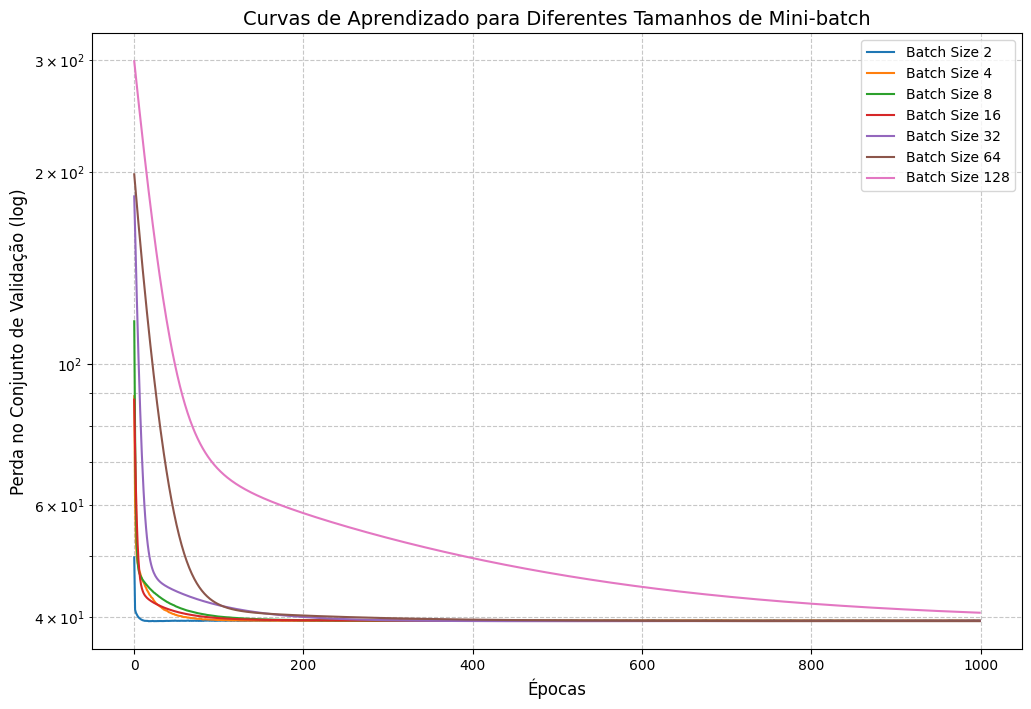

In [30]:
# Hiperparametros
batch_sizes = [2**j for j in range(1, 8)]  
max_epochs = 1000
learning_rate = 0.0001
loss_history = {bs: [] for bs in batch_sizes}

plt.figure(figsize=(12, 8))

# Para cada tamanho de mini-batch
for batch_size in batch_sizes:

    # Inicializar theta
    theta = np.random.normal(size=(X_train_norm.shape[1], 1)) 
    num_samples = X_train_norm.shape[0]
    
    epoch_losses = []
    
    # Para cada época
    for epoch in range(max_epochs):

        # Embaralhar os dados
        permutation = np.random.permutation(num_samples)
        X_shuffled = X_train_norm[permutation]
        y_shuffled = y_train_norm[permutation]
        
        # Tomar batches
        for i in range(0, num_samples, batch_size):

            # Selecionar batch
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Calcular o gradiente em relação a esse batch
            error = X_batch @ theta - y_batch
            grad = (2/batch_size) * (X_batch.T @ error)     
            
            # Atualizar theta
            theta -= learning_rate * grad
        
        # Calcular a perda no conjunto de validação
        val_loss = compute_loss(X_val_norm, y_val_norm, theta)
        epoch_losses.append(val_loss)

        if val_loss < 1e-3:     
            break
    
    loss_history[batch_size] = epoch_losses
    plt.plot(epoch_losses, label=f'Batch Size {batch_size}')

plt.yscale('log')
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Perda no Conjunto de Validação (log)', fontsize=12)
plt.title('Curvas de Aprendizado para Diferentes Tamanhos de Mini-batch', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.show()

In [31]:
theta_ols_norm = np.linalg.pinv(X_train_norm.T @ X_train_norm) @ X_train_norm.T @ y_train_norm

In [36]:
def unnormalized_loss(X_norm, y_true, theta, y_mean, y_std):
    """
    Calcula a perda real em dados normalizados.
    X_norm: np.ndarray de shape (n_samples, n_features) com dados normalizados.
    y_true: np.ndarray de shape (n_samples, 1) com rótulos.
    theta: np.ndarray de shape (n_features, 1) com a solução da regressão normalizada.
    y_mean: float com a média dos rótulos.
    y_std: float com o desvio padrão dos rótulos.
    """
    y_pred_norm = X_norm @ theta
    y_pred = y_pred_norm * y_std + y_mean  
    return np.linalg.norm(y_pred - y_true)**2 / len(y_true)

In [37]:
test_loss_ols = unnormalized_loss(X_test_norm, labels_test, theta_ols_norm, y_mean, y_std)
test_loss_sgd = unnormalized_loss(X_test_norm, labels_test, theta, y_mean, y_std)

print(f"Erro do OLS: {test_loss_ols}")
print(f"Erro do SGD: {test_loss_sgd}")

Erro do OLS: 0.5420849540783116
Erro do SGD: 0.5551458049960466


**Exercício 2.** Agora, você deve implementar uma **Rede RBF** com função de base Gaussiana (veja as notas de aula).
Para os centróides, utilize o output de um modelo de clusterização por K médias, por meio da função que disponibilizamos, como a seguir:

In [39]:
def k_means_factory(n_clusters: int) -> KMeans:
    return KMeans(n_clusters=n_clusters, n_init="auto")

k_means_model = k_means_factory(n_clusters=2)
dumb_data = np.array(
    [[1, 2],
     [1, 4],
     [1, 0],
     [10, 2],
     [10, 4],
     [10, 0]]
)
k_means_model.fit(dumb_data)
cluster_centers = k_means_model.cluster_centers_
print(cluster_centers) # Shape (n_clusters, n_features)

[[10.  2.]
 [ 1.  2.]]


Para determinar o melhor valor de $k$ para o algoritmo de clusterização, treine o modelo (usando a fórmula de OLS) com diferentes valores e escolha o que possuir o menor erro de validação. Faça um gráfico mostrando o valor do erro de validação para diferentes valores de $k$. Mostre também a performance do modelo escolhido no conjunto de teste. Compare com o modelo linear simples da questão anterior. Discuta os resultados.

Para definir o valor do hiper-parâmetro $\gamma$, use a seguinte heurística --- que pode ser achado no livro "Neural Networks", por Simon Haykin:

$$
\gamma = \frac{1}{d_\text{max}^2},
$$

onde $d_\text{max}$ é a maior distância entre um par de centróides. Note que o valor costuma mudar para $k$'s diferentes.


In [38]:
def rbf_transform(X, centers, gamma):
    """
    Transforma as features X para o espaço de características RBF.
    
    X: np.ndarray de shape (n_samples, n_features)
    centers: np.ndarray de shape (n_centers, n_features)
    gamma: float, parâmetro do kernel RBF
    Retorna: np.ndarray de shape (n_samples, n_centers)
    """
    dist_sq = np.linalg.norm(X[:, np.newaxis] - centers, axis=2) ** 2
    return np.exp(-gamma * dist_sq)

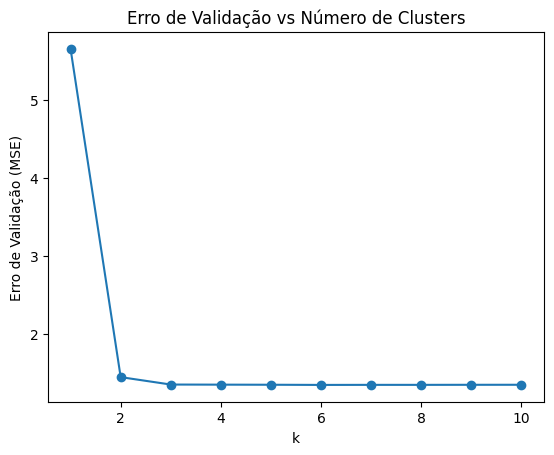

Melhor k: 6
Erro no Teste (RBF): 1.3217
Erro no Teste (Modelo Linear): 1.3217


In [44]:
possible_k_values = range(1, 11)
validation_errors = []

# Para cada valor de k
for k in possible_k_values:

    # Treinar o KMeans
    kmeans = k_means_factory(k)
    kmeans.fit(features)
    # Obter os centros
    centers = kmeans.cluster_centers_
    
    # Calcular a distância máxima entre os centros
    pairwise_dists = np.linalg.norm(centers[:, np.newaxis] - centers, axis=2)
    d_max = pairwise_dists.max()
    gamma = 1.0 / (d_max ** 2) if d_max != 0 else 1.0  # Evitar divisão por zero
    
    # Passar as features de treino e validaçao pelo kernel RBF
    X_train_rbf = rbf_transform(features_train, centers, gamma)
    X_val_rbf = rbf_transform(features_validation, centers, gamma)
    
    # Calcular a solução do modelo linear no espaço RBF	
    theta_lm = np.linalg.pinv(X_train_rbf.T @ X_train_rbf) @ X_train_rbf.T @ labels_train
    
    # Calcular o erro de validação da aproximação linear no espaço RBF
    val_error = compute_loss(X_val_rbf, labels_validation, theta_lm)
    validation_errors.append(val_error)

# Tomar k com menor erro de validação
best_k = possible_k_values[np.argmin(validation_errors)]

# Combinardados de treino e validação
X_train_val = np.concatenate((features_train, features_validation), axis=0)
labels_train_val = np.concatenate((labels_train, labels_validation), axis=0)

# Treinar o KMeans com o melhor k e com os dados completos
kmeans_best = k_means_factory(best_k)
kmeans_best.fit(X_train_val)
centers_best = kmeans_best.cluster_centers_

pairwise_dist_best = np.sqrt(((centers_best[:, np.newaxis, :] - centers_best) ** 2).sum(axis=2))
d_max_best = pairwise_dist_best.max()
gamma_best = 1.0 / (d_max_best ** 2) if d_max_best != 0 else 1.0

# Transformação RBF para teste
X_test_rbf = rbf_transform(features_test, centers_best, gamma_best)

# Treinamento do modelo linear no espaço RBF
X_train_val_rbf_best = rbf_transform(X_train_val, centers_best, gamma_best)
theta_best = np.linalg.pinv(X_train_val_rbf_best.T @ X_train_val_rbf_best) @ X_train_val_rbf_best.T @ labels_train_val
test_error = compute_loss(X_test_rbf, labels_test, theta_best)

plt.plot(possible_k_values, validation_errors, marker='o')
plt.xlabel('k')
plt.ylabel('Erro de Validação (MSE)')
plt.title('Erro de Validação vs Número de Clusters')
plt.show()

print(f"Melhor k: {best_k}")
print(f"Erro no Teste (RBF): {test_error:.4f}")
print(f"Erro no Teste (Modelo Linear): {test_error:.4f}")

## Regressão logística

O pedaço de código abaixo carrega o banco de dados 'breast cancer' e adiciona uma coluna de bias. Além disse, ele o particiona em treino e teste.

1. Implemente a estimativa de máximo a posteriori para um modelo de regressão logística com priori $\mathcal{N}(0, c I)$ com $c=100$ usando esse banco de dados;
2. Implemente a aproximação de Laplace para o mesmo modelo;
3. Implemente uma aproximação variacional usando uma Gaussiana diagonal e o truque da reparametrização;
4. Calcule a accuracy no teste para todas as opções acima --- no caso das 2 últimas, a prob predita é $\int_\theta p(y|x, \theta) q(\theta)$;
5. Para cada uma das 3 técnicas, plote um gráfico com a distribuição das entropias para as predições corretas e erradas (separadamente), use a função kdeplot da biblioteca seaborn.
6. Comente os resultados, incluindo uma comparação dos gráficos das entropias.

Explique sua implementação também! 

Para (potencialmente) facilitar sua vida: use PyTorch, Adam como otimizador (é uma variação SGD) com lr=0.001, use o banco de treino inteiro ao invés de minibatchces, use binary_cross_entropy_with_logits para implementar a -log verossimilhança, use torch.autograd.functional para calcular a Hessiana. Você pode usar as bibliotecas importadas na primeira célula a vontade. Verifique a documentação de binary_cross_entropy_with_logits para garantir que a sua priori está implementada corretamente, preservando as proporções devidas. Use 10000 amostras das aproximações para calcular suas predições.

In [ ]:
data =  load_breast_cancer()
N = len(data.data)
Ntrain = int(np.ceil(N*0.6))
perm = np.random.permutation(len(data.data))
X = torch.tensor(data.data).float()
X = torch.cat((X, torch.ones((X.shape[0], 1))), axis=1) 
y = torch.tensor(data.target).float()

Xtrain, ytrain = X[perm[:Ntrain]], y[perm[:Ntrain]]
Xtest, ytest = X[perm[Ntrain:]], y[perm[Ntrain:]]

In [ ]:
def sigmoid(z):
    """
    Calcula a função sigmoidal para um tensor z.
    z: torch.Tensor
    """
    return 1 / (1 + torch.exp(-z))


def logistic_regression(X, weights):
    """
    Calcula a predição da regressão logística.
    X: torch.Tensor de shape (n_samples, n_features)
    weights: torch.Tensor de shape (n_features, 1)
    """
    return sigmoid(torch.matmul(X, weights))


def mse_with_regularization(X, y, weights, lambda_reg):
    """
    Calcula a perda MSE com regularização L2.
    X: torch.Tensor de shape (n_samples, n_features)
    y: torch.Tensor de shape (n_samples, 1)
    weights: torch.Tensor de shape (n_features, 1)
    lambda_reg: float, parâmetro de regularização
    """
    predictions = logistic_regression(X, weights)
    mse_loss = torch.mean((predictions - y.view(-1, 1)) ** 2)  # MSE
    l2_penalty = lambda_reg * torch.sum(weights ** 2)  # Regularização L2
    return mse_loss + l2_penalty



In [ ]:
### MAP ###
#  Estimar o MAP é equivalente a minimizar a MSE com regularização L2

# Inicialização de pesos (usando uma inicialização aleatória)
input_dim = Xtrain.shape[1]
weights = torch.randn(input_dim, 1, requires_grad=True) * 0.01  # Inicialização aleatória

# Permitir que o atributo .grad seja preenchido durante o backpropagation
weights.retain_grad()

# Parâmetro de regularização para N(0, 100*I)
lambda_reg = 1 / (2 * 100)

learning_rate = 0.001  
num_epochs = 500

for epoch in range(num_epochs):
    # Calcule a função de custo
    loss = mse_with_regularization(Xtrain, ytrain, weights, lambda_reg)
    
    # Calcule os gradientes com backpropagation
    loss.backward(retain_graph=True)

    with torch.no_grad():   # Desativar o cálculo de gradientes (otimiza memória)
        weights -= learning_rate * weights.grad

    # Zera os gradientes para a próxima iteração
    weights.grad.zero_()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print("\n ------------------------------------- \n")

w_map = weights.clone().detach()

# Conjunto de teste
with torch.no_grad():
    ypred = logistic_regression(Xtest, weights)
    predictions = (ypred > 0.5).float()  # Threshold de 0.5
    accuracy = torch.mean((predictions == ytest.view(-1, 1)).float())
    print(f'Acurácia: {accuracy.item():.4f}')

In [ ]:
### Aproximação de Laplace ###

import torch.autograd.functional as AF

# Função de verossimilhança negativa (log-verossimilhança)
def negative_log_likelihood(X, y, weights):
    """
    Calcula a log-verossimilhança negativa para o modelo de regressão logística.
    """
    logits = logistic_regression(X, weights)
    nll = torch.nn.functional.binary_cross_entropy_with_logits(logits, y.view(-1, 1))

    return nll 

def compute_hessian(X, y, weights):
    """
    Calcula a Hessiana em relação aos pesos.
    """
    loss_fn = lambda w: negative_log_likelihood(X, y, w)
    hessian = AF.hessian(loss_fn, weights)

    return hessian

def laplace(x):
    """
    Calcula a aproximação de laplace para o modelo de regressão logística.
    x: torch.Tensor de shape (n_features, 1)
    """
    hessian = compute_hessian(Xtrain, ytrain, x, lambda_reg)
    cov = torch.inverse(hessian)
    mean = np.mean(hessian, axis=0)
    laplace = negative_log_likelihood(Xtrain, ytrain, x) + (x - mean).T @ cov @ (x - mean)
    
    return laplace


weights = w_map

# Aproximação de Laplace centrada no MAP
laplace_value = laplace(Xtrain, ytrain, weights)

# Previsão com a regressão logística
logits_test = logistic_regression(Xtest, weights)
probs = torch.sigmoid(logits_test)

# Considerar o label de maior probabilidade
probs = probs.detach().numpy()
predicted_labels = probs.argmax(axis=1)
accuracy = (predicted_labels == ytest.numpy()).mean()

print(f"Acurácia: {accuracy:.4f}")  ### ERRADO

In [ ]:
### Aproximação Variacional ###